# ノートブック09: MLP回帰と波形予測

## 学習目標

このノートブックでは、MLPRegressorを使った回帰問題と時系列予測を学びます:

1. **MLPRegressor**
   - 分類と回帰の違い
   - 回帰用の評価指標

2. **波形生成**
   - 複雑な高調波
   - 減衰振動
   - AM信号とチャープ

3. **時系列特徴量エンジニアリング**
   - ラグ特徴量
   - 最適なラグ数の決定

4. **波形予測**
   - 1ステップ先予測
   - 多ステップ予測
   - 再帰的予測

5. **実践的なベストプラクティス**
   - 時系列データの扱い
   - モデルの診断と改善

---

## セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
np.random.seed(42)

print("Setup complete!")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


Setup complete!


---

## 1. 複雑な波形の生成

様々な波形を生成して、MLPの予測能力を評価します。

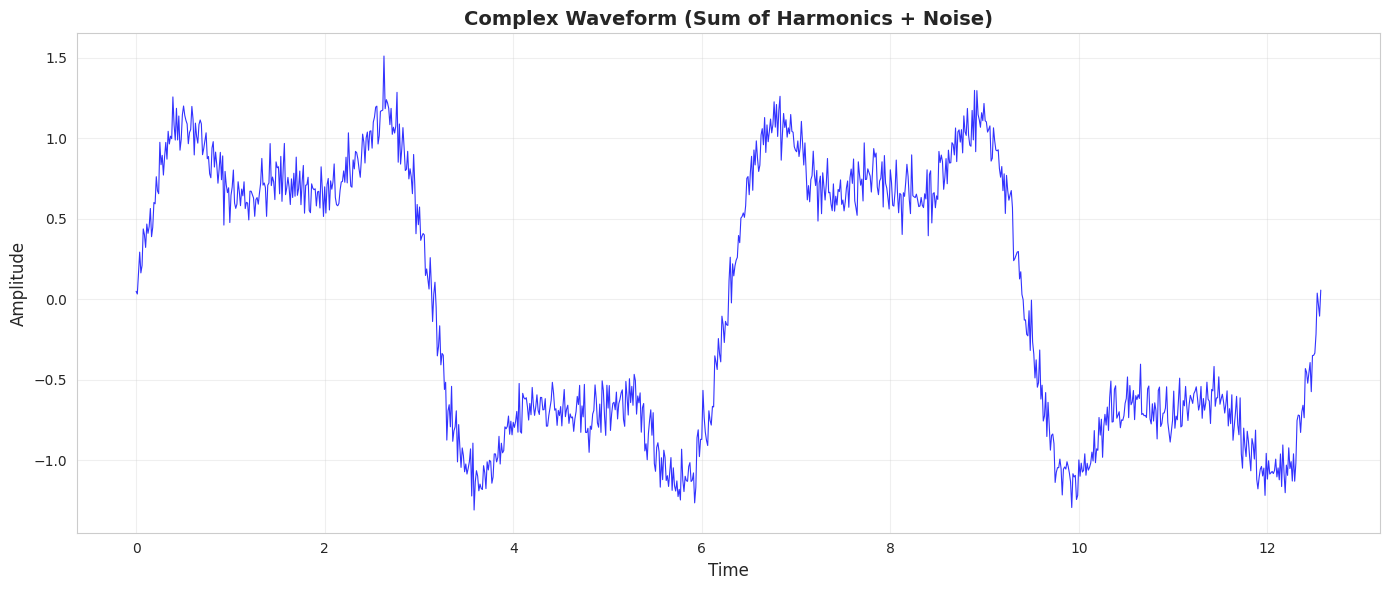

Waveform length: 1000 points
Value range: [-1.31, 1.51]


In [2]:
def generate_complex_waveform(n_points=1000, noise_level=0.1):
    """複雑な高調波信号"""
    t = np.linspace(0, 4 * np.pi, n_points)
    y = (np.sin(t) + 0.5 * np.sin(3 * t) + 0.25 * np.sin(5 * t))
    y += noise_level * np.random.randn(n_points)
    return t, y

def generate_damped_oscillation(n_points=1000, damping=0.3, noise=0.05):
    """減衰振動"""
    t = np.linspace(0, 4 * np.pi, n_points)
    y = np.exp(-damping * t) * np.sin(5 * t)
    y += noise * np.random.randn(n_points)
    return t, y

def generate_am_signal(n_points=1000, carrier_freq=20, mod_freq=2, noise=0.05):
    """AM (振幅変調) 信号"""
    t = np.linspace(0, 4 * np.pi, n_points)
    carrier = np.sin(carrier_freq * t)
    modulator = 1 + 0.5 * np.sin(mod_freq * t)
    y = carrier * modulator
    y += noise * np.random.randn(n_points)
    return t, y

def generate_chirp(n_points=1000, noise=0.05):
    """チャープ信号 (周波数増加)"""
    t = np.linspace(0, 4 * np.pi, n_points)
    y = np.sin(t * (1 + t/4))
    y += noise * np.random.randn(n_points)
    return t, y

# 波形生成
t, y = generate_complex_waveform(n_points=1000, noise_level=0.1)

plt.figure(figsize=(14, 6))
plt.plot(t, y, 'b-', linewidth=0.8, alpha=0.8)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title('Complex Waveform (Sum of Harmonics + Noise)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Waveform length: {len(y)} points")
print(f"Value range: [{y.min():.2f}, {y.max():.2f}]")

---

## 2. 時系列特徴量エンジニアリング

時系列予測には、**ラグ特徴量** (過去の値) を使用します。

In [3]:
def create_lag_features(y, n_lags=10):
    """
    ラグ特徴量を作成
    X[i] = [y[i-n_lags], y[i-n_lags+1], ..., y[i-1]]
    y_target[i] = y[i]
    """
    X = []
    y_target = []
    
    for i in range(n_lags, len(y)):
        X.append(y[i-n_lags:i])
        y_target.append(y[i])
    
    return np.array(X), np.array(y_target)

# ラグ特徴量を作成
n_lags = 20
X, y_target = create_lag_features(y, n_lags=n_lags)

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y_target.shape}")
print(f"\nEach sample uses {n_lags} previous time points to predict the next value.")

Feature shape: (980, 20)
Target shape: (980,)

Each sample uses 20 previous time points to predict the next value.


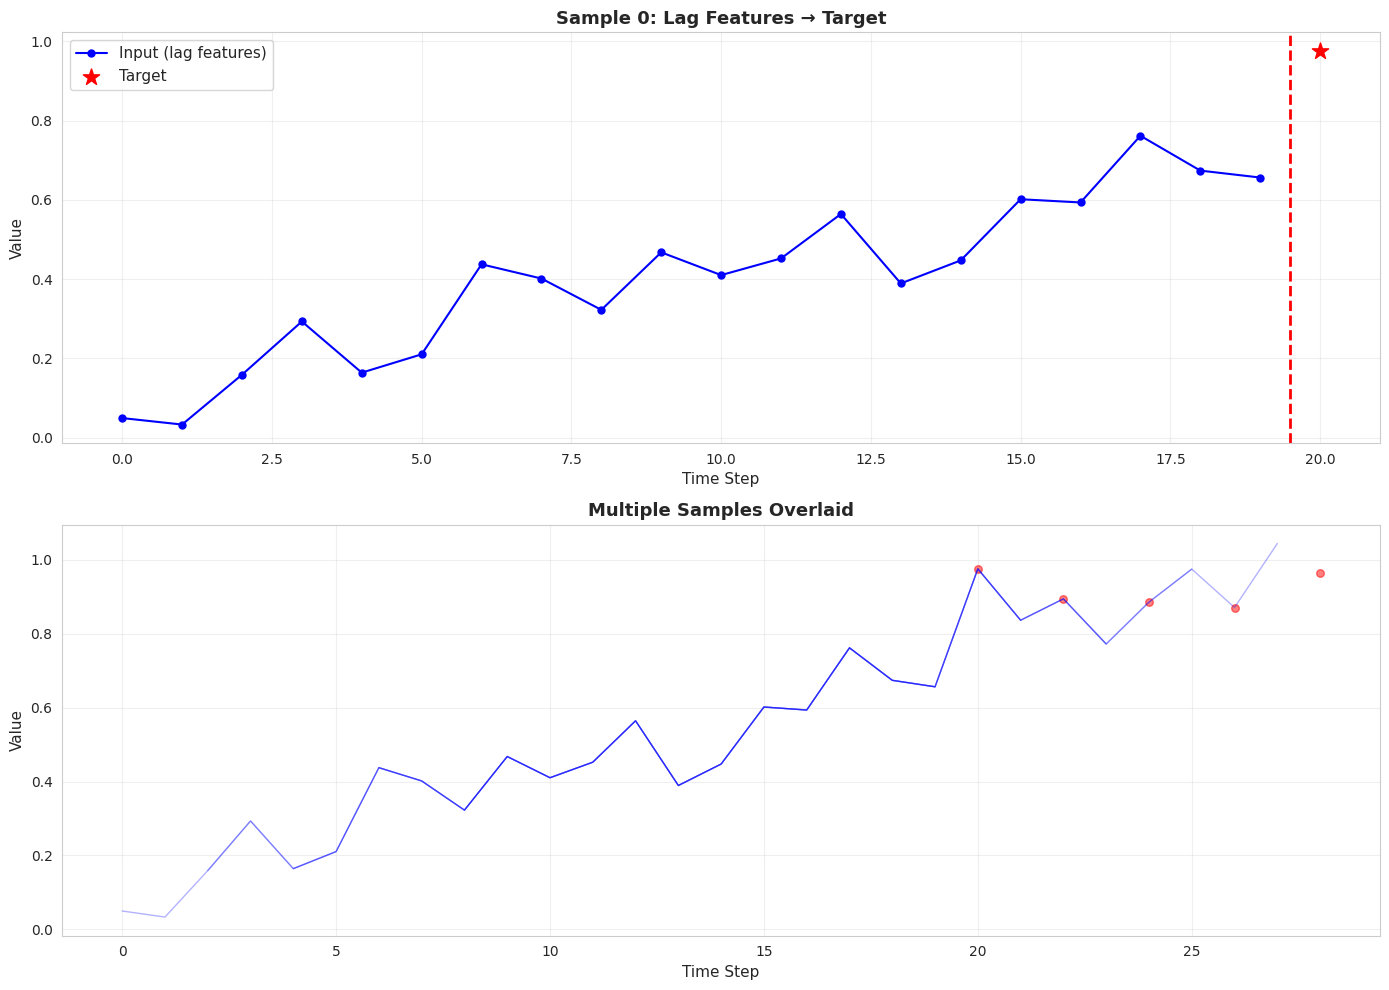

In [4]:
# ラグ特徴量の可視化
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# サンプル1つを表示
sample_idx = 0
axes[0].plot(range(n_lags), X[sample_idx], 'bo-', label='Input (lag features)', markersize=5)
axes[0].axvline(x=n_lags-0.5, color='r', linestyle='--', linewidth=2)
axes[0].scatter([n_lags], [y_target[sample_idx]], c='r', s=150, zorder=5, 
                label='Target', marker='*')
axes[0].set_xlabel('Time Step', fontsize=11)
axes[0].set_ylabel('Value', fontsize=11)
axes[0].set_title(f'Sample {sample_idx}: Lag Features → Target', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 複数サンプルを重ねて表示
for i in range(0, min(10, len(X)), 2):
    axes[1].plot(range(i, i + n_lags), X[i], 'b-', alpha=0.3, linewidth=1)
    axes[1].scatter([i + n_lags], [y_target[i]], c='r', s=30, alpha=0.5)

axes[1].set_xlabel('Time Step', fontsize=11)
axes[1].set_ylabel('Value', fontsize=11)
axes[1].set_title('Multiple Samples Overlaid', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 3. MLPRegressorで波形予測

In [5]:
# データ分割 (時系列なのでshuffleしない!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, shuffle=False
)

# スケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# MLPRegressorの訓練
mlp_reg = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

mlp_reg.fit(X_train_scaled, y_train)

# 予測
y_pred_train = mlp_reg.predict(X_train_scaled)
y_pred_test = mlp_reg.predict(X_test_scaled)

print("\nModel Performance:")
print("="*60)
print(f"Training R²:   {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²:       {r2_score(y_test, y_pred_test):.4f}")
print(f"Test RMSE:     {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"Test MAE:      {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"\nIterations: {mlp_reg.n_iter_}")

Training samples: 784
Test samples: 196

Model Performance:
Training R²:   0.9816
Test R²:       0.7594
Test RMSE:     0.1105
Test MAE:      0.0883

Iterations: 51


### 波形予測の可視化

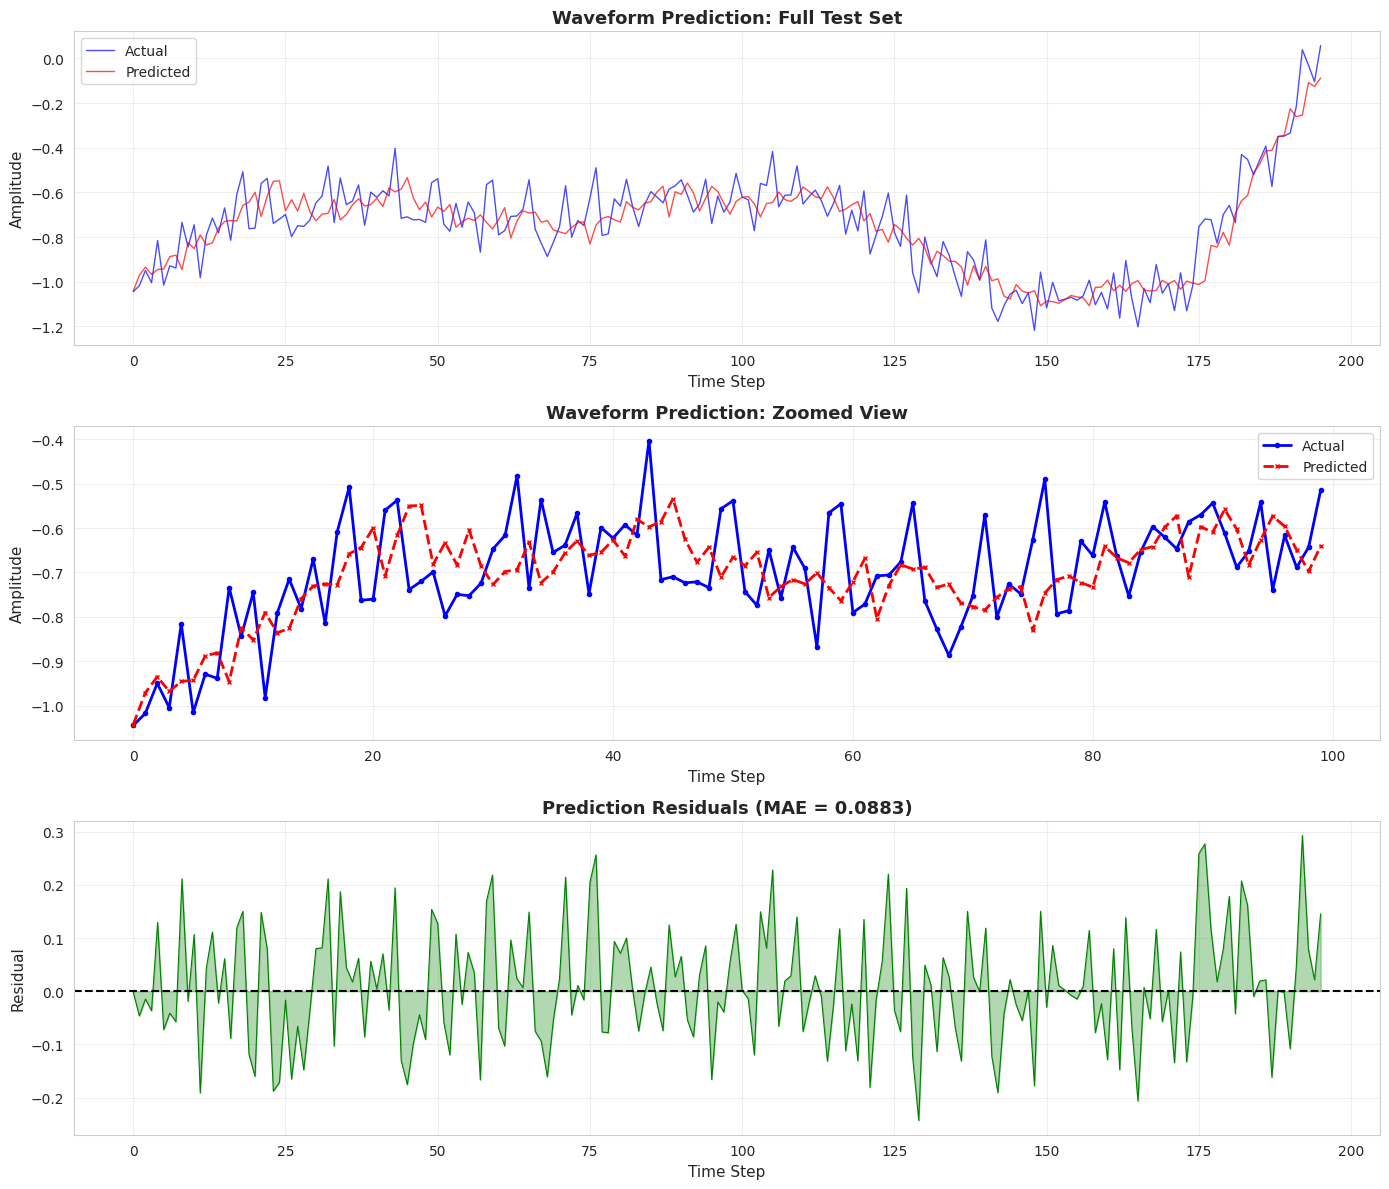

In [6]:
# 予測結果の可視化
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 全体の比較
axes[0].plot(y_test, 'b-', linewidth=1, label='Actual', alpha=0.7)
axes[0].plot(y_pred_test, 'r-', linewidth=1, label='Predicted', alpha=0.7)
axes[0].set_xlabel('Time Step', fontsize=11)
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('Waveform Prediction: Full Test Set', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ズーム表示
zoom_start, zoom_end = 0, 100
axes[1].plot(range(zoom_start, zoom_end), y_test[zoom_start:zoom_end], 'b-',
             linewidth=2, label='Actual', marker='o', markersize=3)
axes[1].plot(range(zoom_start, zoom_end), y_pred_test[zoom_start:zoom_end], 'r--',
             linewidth=2, label='Predicted', marker='x', markersize=3)
axes[1].set_xlabel('Time Step', fontsize=11)
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('Waveform Prediction: Zoomed View', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# 残差
residuals = y_test - y_pred_test
axes[2].plot(residuals, 'g-', linewidth=0.8)
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=1.5)
axes[2].fill_between(range(len(residuals)), 0, residuals, alpha=0.3, color='green')
axes[2].set_xlabel('Time Step', fontsize=11)
axes[2].set_ylabel('Residual', fontsize=11)
axes[2].set_title(f'Prediction Residuals (MAE = {mean_absolute_error(y_test, y_pred_test):.4f})',
                  fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

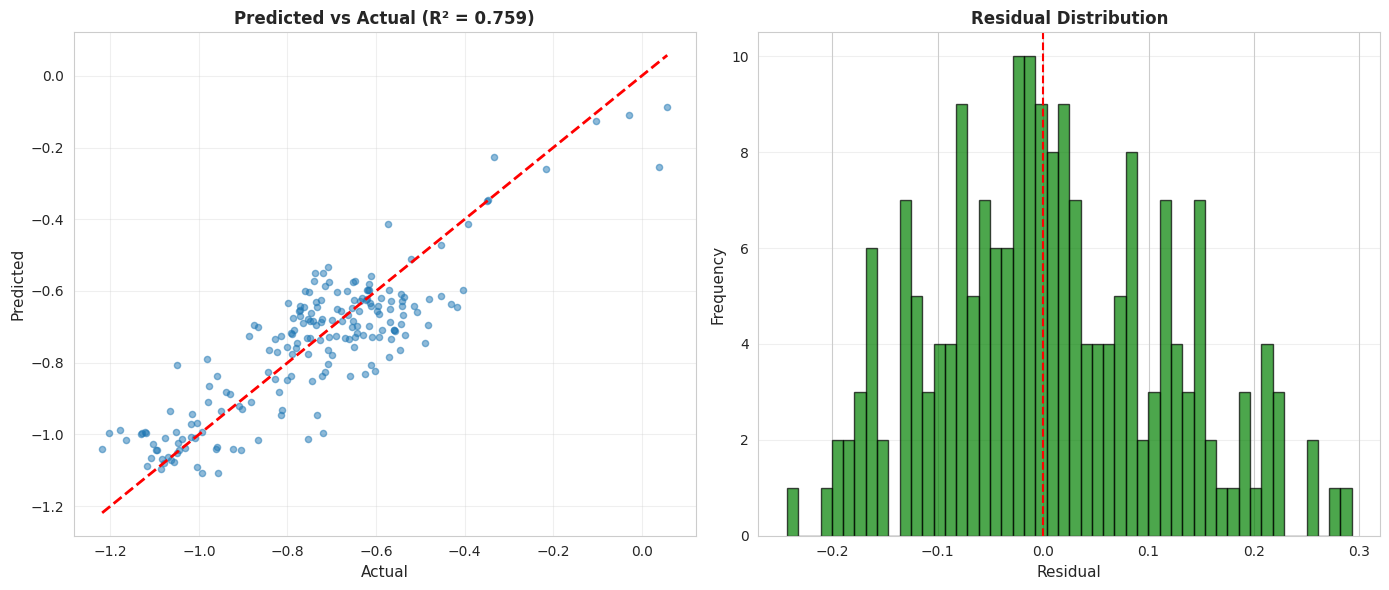

In [7]:
# 予測 vs 実際の散布図
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 散布図
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2)
axes[0].set_xlabel('Actual', fontsize=11)
axes[0].set_ylabel('Predicted', fontsize=11)
axes[0].set_title(f'Predicted vs Actual (R² = {r2_score(y_test, y_pred_test):.3f})',
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 残差分布
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Residual', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---

## 4. ラグ数の影響

最適なラグ数を見つけます。

In [8]:
# 異なるラグ数でテスト
lag_values = [5, 10, 20, 30, 50, 70]

results = []

for n_lags in lag_values:
    # 特徴量作成
    X_lag, y_lag = create_lag_features(y, n_lags=n_lags)
    
    # 分割
    X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
        X_lag, y_lag, test_size=0.2, shuffle=False
    )
    
    # スケーリング
    scaler_lag = StandardScaler()
    X_train_lag_scaled = scaler_lag.fit_transform(X_train_lag)
    X_test_lag_scaled = scaler_lag.transform(X_test_lag)
    
    # 訓練
    mlp_lag = MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    mlp_lag.fit(X_train_lag_scaled, y_train_lag)
    
    # 評価
    y_pred_lag = mlp_lag.predict(X_test_lag_scaled)
    
    results.append({
        'n_lags': n_lags,
        'R²': r2_score(y_test_lag, y_pred_lag),
        'RMSE': np.sqrt(mean_squared_error(y_test_lag, y_pred_lag)),
        'MAE': mean_absolute_error(y_test_lag, y_pred_lag)
    })

df_lags = pd.DataFrame(results)

print("\nEffect of Number of Lags:")
print(df_lags.to_string(index=False))


Effect of Number of Lags:
 n_lags       R²     RMSE      MAE
      5 0.745908 0.114382 0.092167
     10 0.739797 0.115366 0.093922
     20 0.759363 0.110547 0.088322
     30 0.745405 0.113334 0.093298
     50 0.703690 0.122303 0.096661
     70 0.663346 0.131139 0.107865


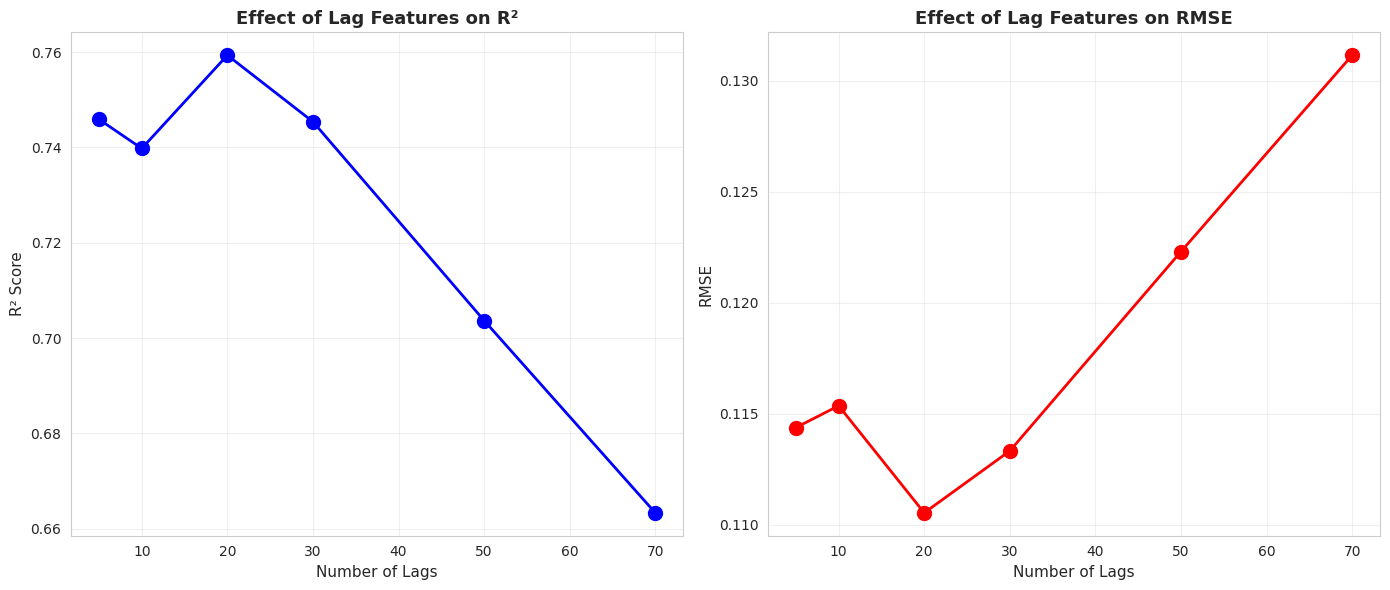


Best number of lags: 20


In [9]:
# ラグ数の影響を可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(df_lags['n_lags'], df_lags['R²'], 'bo-', markersize=10, linewidth=2)
axes[0].set_xlabel('Number of Lags', fontsize=11)
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('Effect of Lag Features on R²', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_lags['n_lags'], df_lags['RMSE'], 'ro-', markersize=10, linewidth=2)
axes[1].set_xlabel('Number of Lags', fontsize=11)
axes[1].set_ylabel('RMSE', fontsize=11)
axes[1].set_title('Effect of Lag Features on RMSE', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_lag = df_lags.loc[df_lags['R²'].idxmax(), 'n_lags']
print(f"\nBest number of lags: {int(best_lag)}")

---

## 5. 異なる波形タイプでの予測

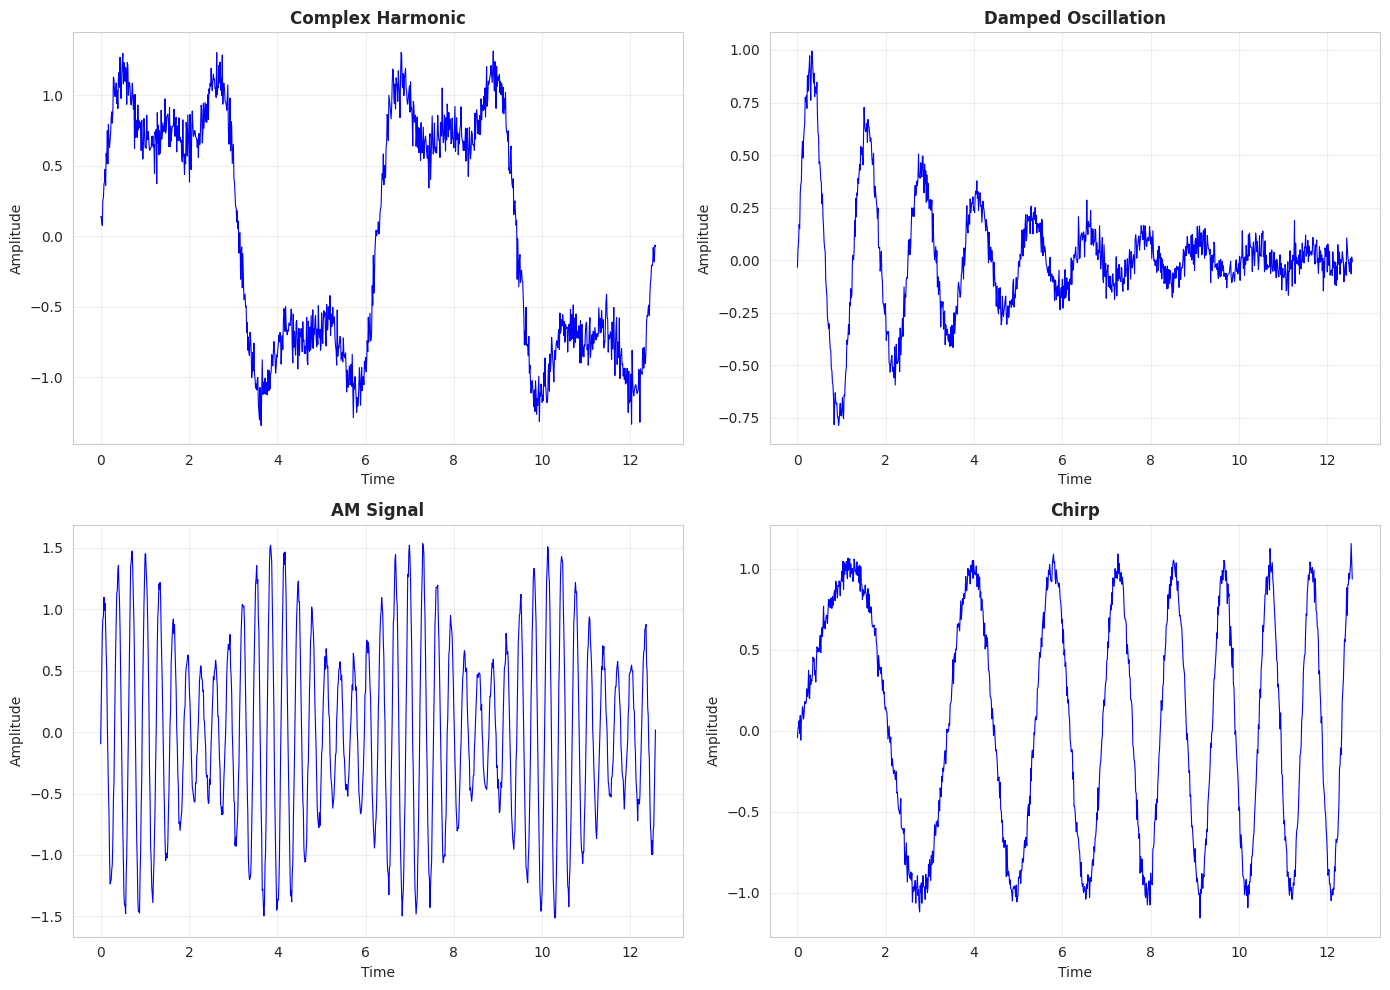

In [10]:
# すべての波形を生成
waveforms = {
    'Complex Harmonic': generate_complex_waveform(1000, 0.1),
    'Damped Oscillation': generate_damped_oscillation(1000, 0.3, 0.05),
    'AM Signal': generate_am_signal(1000, 20, 2, 0.05),
    'Chirp': generate_chirp(1000, 0.05)
}

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, (t, y_wave)) in enumerate(waveforms.items()):
    axes[idx].plot(t, y_wave, 'b-', linewidth=0.8)
    axes[idx].set_xlabel('Time', fontsize=10)
    axes[idx].set_ylabel('Amplitude', fontsize=10)
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

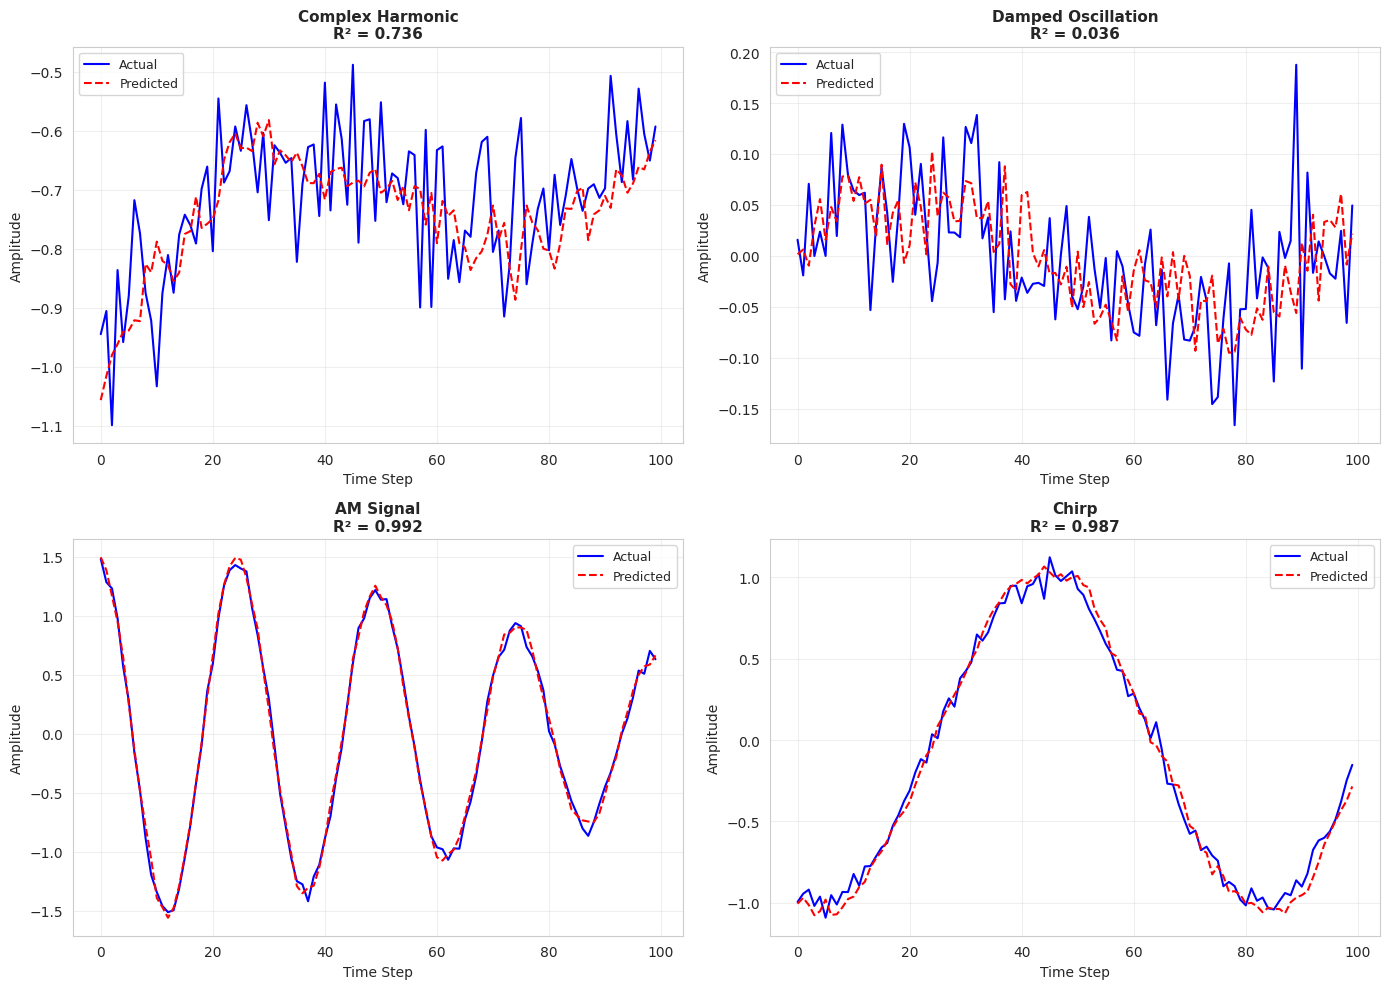


Waveform Prediction Results:
          Waveform       R²     RMSE      MAE
  Complex Harmonic 0.735734 0.114683 0.089536
Damped Oscillation 0.035579 0.060231 0.048017
         AM Signal 0.992302 0.060966 0.050070
             Chirp 0.987328 0.081835 0.063429


In [11]:
# 各波形でMLPを訓練
n_lags = 30
waveform_results = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, (t, y_wave)) in enumerate(waveforms.items()):
    # 特徴量作成
    X, y_target = create_lag_features(y_wave, n_lags=n_lags)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_target, test_size=0.2, shuffle=False
    )
    
    # スケーリング
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 訓練
    mlp = MLPRegressor(
        hidden_layer_sizes=(200, 100),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    
    # 予測
    y_pred = mlp.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    
    waveform_results.append({
        'Waveform': name,
        'R²': r2,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    })
    
    # プロット
    axes[idx].plot(y_test[:100], 'b-', linewidth=1.5, label='Actual')
    axes[idx].plot(y_pred[:100], 'r--', linewidth=1.5, label='Predicted')
    axes[idx].set_title(f'{name}\nR² = {r2:.3f}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Time Step', fontsize=10)
    axes[idx].set_ylabel('Amplitude', fontsize=10)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

df_waveforms = pd.DataFrame(waveform_results)
print("\nWaveform Prediction Results:")
print(df_waveforms.to_string(index=False))

---

## 6. 多ステップ予測

再帰的に複数ステップ先を予測します。

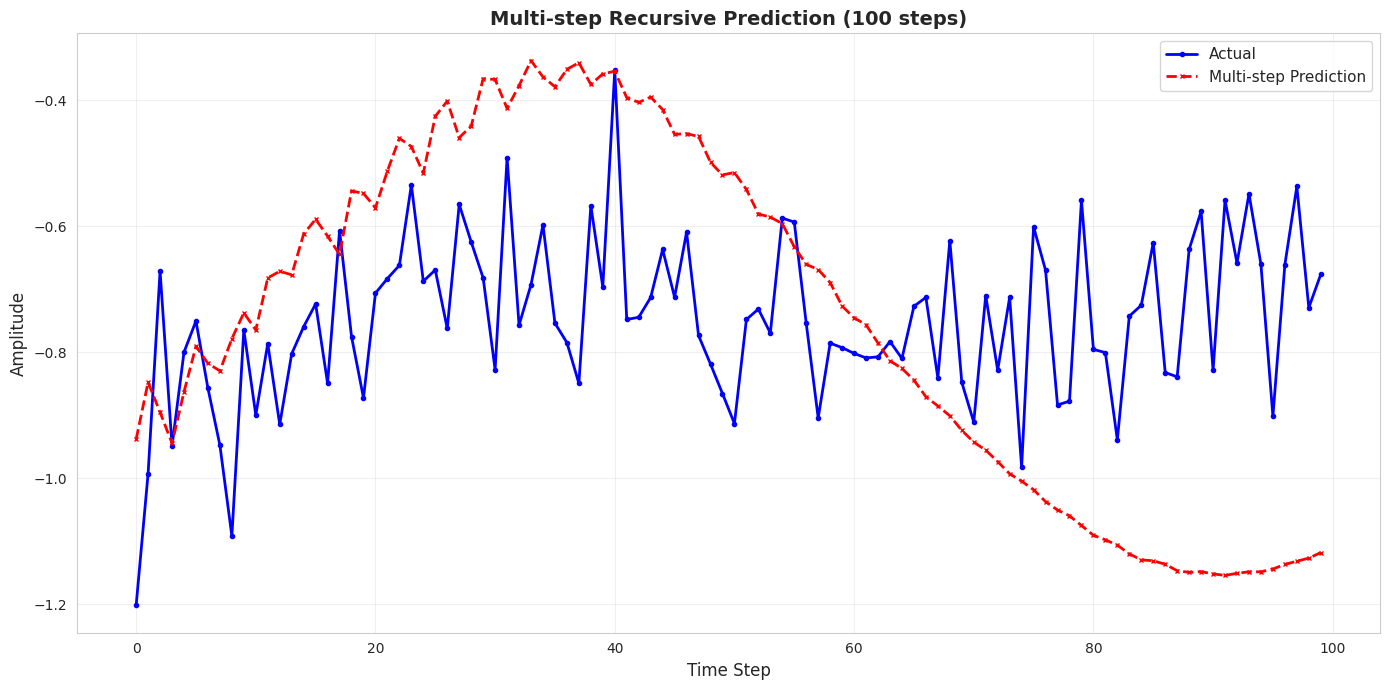


Multi-step Prediction Performance:
R²: -3.8508
RMSE: 0.2876
MAE: 0.2401

Note: Error accumulates with more prediction steps!


In [12]:
# 最適なモデルを訓練
t, y = generate_complex_waveform(1000, 0.1)
n_lags = 30

X, y_target = create_lag_features(y, n_lags=n_lags)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(
    hidden_layer_sizes=(200, 100),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

# 再帰的予測関数
def recursive_predict(model, scaler, initial_sequence, n_steps):
    """複数ステップ先を再帰的に予測"""
    predictions = []
    current_seq = initial_sequence.copy()
    
    for _ in range(n_steps):
        # スケーリングして予測
        x_scaled = scaler.transform(current_seq.reshape(1, -1))
        pred = model.predict(x_scaled)[0]
        predictions.append(pred)
        
        # シーケンスを更新
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = pred
    
    return np.array(predictions)

# 多ステップ予測
n_predict = 100
initial_seq = X_test[0]
y_multi = recursive_predict(mlp, scaler, initial_seq, n_predict)
y_actual = y_test[:n_predict]

# プロット
plt.figure(figsize=(14, 7))
plt.plot(y_actual, 'b-', linewidth=2, label='Actual', marker='o', markersize=3)
plt.plot(y_multi, 'r--', linewidth=2, label='Multi-step Prediction', marker='x', markersize=3)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title(f'Multi-step Recursive Prediction ({n_predict} steps)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMulti-step Prediction Performance:")
print(f"R²: {r2_score(y_actual, y_multi):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_actual, y_multi)):.4f}")
print(f"MAE: {mean_absolute_error(y_actual, y_multi):.4f}")
print("\nNote: Error accumulates with more prediction steps!")

---

## まとめ

### 波形予測のベストプラクティス

1. **特徴量エンジニアリング**
   - ラグ特徴量: 過去の値を予測子として使用
   - 最適なラグ数: 信号の周期性に依存
   - 微分特徴量: 変化率も有用

2. **アーキテクチャ**
   - 開始: (100, 50) または (200, 100)
   - 複雑なパターン: より深いネットワーク
   - 入力サイズ = ラグ特徴量の数

3. **訓練のポイント**
   - 時系列データはシャッフルしない!
   - Early stoppingを使用
   - StandardScalerで特徴量をスケーリング

4. **評価指標**
   - R²: 説明率
   - RMSE: 二乗平均平方根誤差
   - MAE: 平均絶対誤差

5. **多ステップ予測**
   - 再帰的: 1ステップずつ予測してフィードバック
   - 誤差蓄積: ステップが増えると精度低下
   - 直接的多出力モデルも検討

### MLPRegressorの注意点

- **分類との違い**: 出力が連続値
- **活性化関数**: 出力層は線形 (恒等関数)
- **損失関数**: 平均二乗誤差 (MSE)

### 実践的アドバイス

1. まずシンプルなモデルから開始
2. ラグ数を実験的に決定
3. 学習曲線で診断
4. 予測を可視化して確認
5. 残差分析で改善点を発見

---

**次のステップ**: ノートブック10で、より高度なニューラルネットワーク技術を学びます!
